---
title: AERO 417 Project 1
---

In [1]:
import numpy as np
from scipy.optimize import fsolve
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sy

## Constant Mean Diameter (CMD)

In [2]:
# Input Constraints
takeoff_thrust = 12000
pressure_ambient = 1.01
temperature_ambient = 288

P_compressor = 4.15
m_dot = 20
turbine_inlet_temperature = 1100

Cp = 1005
gamma = 1.4
R = 287

compressor_polytropic_efficiency = 0.9
n_compressor = -1/(1/compressor_polytropic_efficiency*(gamma-1)/gamma-1)

# Design Variables
N = 250
U_tip = 355.3
C_axial = 150
rr_rt = 0.5

### Compressor Geometry

Geometry:
Inlet
Tip- 0.13055582635997443
Root- 0.052222330543989774
Mean- 0.0913890784519821
Outlet
Tip- 0.10388188527248432
Root- 0.07889627163147989
Mean- 0.0913890784519821


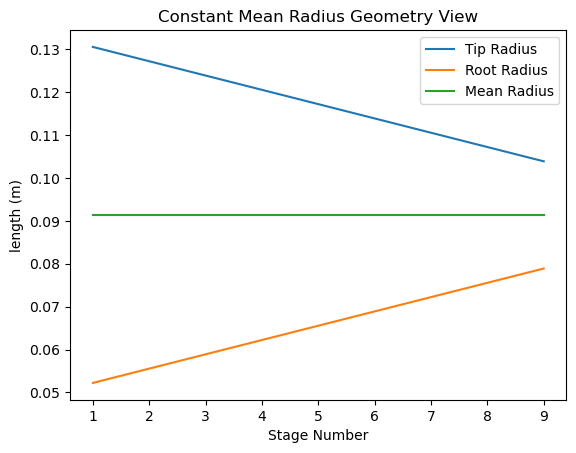

In [23]:
T01 = temperature_ambient
P01 = pressure_ambient
C1 = C_axial

T1 = T01-C1**2/2/Cp
P1 = P01*(T1/T01)**(gamma/(gamma-1))
rho1 = P1/R/T1*100000

inlet_radius_tip = (m_dot/(np.pi*rho1*C1)/(1-rr_rt**2))**0.5
inlet_radius_root = rr_rt*inlet_radius_tip
inlet_radius_mean = (inlet_radius_tip+inlet_radius_root)/2

V1_tangent = (U_tip**2+C_axial**2)**0.5
a1 = (gamma*R*T1)**0.5
M1 = V1_tangent/a1

C2 = C1
T02 = T01*(P_compressor)**((n_compressor-1)/n_compressor)
P02 = P_compressor*P01
T2 = T02-C2**2/2/Cp
P2 = P02*(T2/T02)**(gamma/(gamma-1))
rho2 = P2/R/T2*100000
A2 = m_dot/rho2/C2

outlet_radius_mean = inlet_radius_mean
h = A2/2/np.pi/outlet_radius_mean
outlet_radius_tip = outlet_radius_mean+h/2
outlet_radius_root = outlet_radius_mean-h/2

print("Geometry:")
print("Inlet")
print("Tip-",inlet_radius_tip)
print("Root-",inlet_radius_root)
print("Mean-",inlet_radius_mean)
print("Outlet")
print("Tip-",outlet_radius_tip)
print("Root-",outlet_radius_root)
print("Mean-",outlet_radius_mean)

U_mean = 2*np.pi*N*outlet_radius_mean
Beta1 = np.arctan(U_mean/C_axial)
V1 = C_axial/np.cos(Beta1)
V2 = 0.72*V1
Beta2 = np.arccos(C_axial/V2)

ideal_temperature_rise = U_mean*C_axial*(np.tan(Beta1)-np.tan(Beta2))/Cp
num_stages = int(np.ceil((T2-T1)/ideal_temperature_rise)+1)

tips = np.linspace(inlet_radius_tip,outlet_radius_tip,num_stages)
roots = np.linspace(inlet_radius_root,outlet_radius_root,num_stages)
means = [(t+r)/2 for t,r in zip(tips,roots)]

x = range(1,num_stages+1)

plt.figure()
plt.plot(x,tips,label="Tip Radius")
plt.plot(x,roots,label="Root Radius")
plt.plot(x,means,label="Mean Radius")
plt.legend()
plt.xticks(x)
plt.xlabel("Stage Number")
plt.ylabel("length (m)")
plt.title("Constant Mean Radius Geometry View")
plt.show()

In [24]:
mean_temperature_rise = (T2-T1)/num_stages

min_temperature_rise = mean_temperature_rise-mean_temperature_rise%(np.ceil(mean_temperature_rise/5))
max_temperature_rise = ((T2-T1)-2*min_temperature_rise)/(num_stages-2)
temperature_rise = []
temperature_rise.append(min_temperature_rise)
temperature_rise.extend((num_stages-2)*[max_temperature_rise])
temperature_rise.append(min_temperature_rise)

work_done = [max(0.98-i*0.05,0.83) for i in range(num_stages)]

C1_swirl = [0]

swirl_change = Cp*temperature_rise[0]/work_done[0]/U_mean
C2_swirl = [C1_swirl[-1]+swirl_change]

Beta1 = np.arctan(U_mean/C_axial)
Alpha1 = np.arctan(C1_swirl[-1]/C_axial)
Beta2 = np.arctan((U_mean-C2_swirl[-1])/C_axial)
Alpha2 = np.arctan(C2_swirl[-1]/C_axial)

De_Haller = [np.cos(Beta1)/np.cos(Beta2)]

P_ratio = [(1+compressor_polytropic_efficiency*temperature_rise[0]/T01)**(gamma/(gamma-1))]

Inlet_P0 = [P01]
Outlet_P0 = [P_ratio[-1]*P01]

Inlet_T0 = [T01]
Outlet_T0 = [T01+temperature_rise[0]]

Lambda = [1-(C2_swirl[-1]+C1_swirl[-1])/2/U_mean,0.7]
Lambda.extend((num_stages-2)*[0.5])

def beta_equations(x,idx):
    return [temperature_rise[idx]*Cp/work_done[idx]/U_mean/C_axial-(np.tan(x[0])-np.tan(x[1])),
            Lambda[idx]/C_axial*2*U_mean-(np.tan(x[0])+np.tan(x[1]))]

for stage_num in range(1,num_stages):
    Beta1,Beta2 = fsolve(beta_equations,[1,1],args=stage_num)
    Alpha1 = np.arctan(U_mean/C_axial-np.tan(Beta1))
    Alpha2 = np.arctan(U_mean/C_axial-np.tan(Beta2))
    C1_swirl.append(C_axial*np.tan(Alpha1))
    C2_swirl.append(C_axial*np.tan(Alpha2))
    De_Haller.append(np.cos(Beta1)/np.cos(Beta2))
    P_ratio.append((1+compressor_polytropic_efficiency*temperature_rise[stage_num]/Outlet_T0[-1])**(gamma/(gamma-1)))
    Inlet_P0.append(Outlet_P0[-1])
    Outlet_P0.append(P_ratio[-1]*Inlet_P0[-1])
    Inlet_T0.append(Outlet_T0[-1])
    Outlet_T0.append(Inlet_T0[-1]+temperature_rise[stage_num])
    
df = {"Inlet_T0":Inlet_T0,
      "Outlet_T0":Outlet_T0,
      "Inlet_P0":Inlet_P0,
      "Outlet_P0":Outlet_P0,
      "P_ratio":P_ratio,
      "Inlet_swirl":C1_swirl,
      "Outlet_swirl":C2_swirl,
      "De_Haller":De_Haller}
df = pd.DataFrame(df)
df.index+=1
df

,Inlet_T0,Outlet_T0,Inlet_P0,Outlet_P0,P_ratio,Inlet_swirl,Outlet_swirl,De_Haller
1,288.150000,308.150000,1.013250,1.249764,1.233421,0.000000,83.552548,0.782574
2,308.150000,330.280952,1.249764,1.552414,1.242166,24.930230,122.355793,0.748765
3,330.280952,352.411904,1.552414,1.901322,1.224752,71.257799,174.218906,0.750749
4,352.411904,374.542856,1.901322,2.299969,1.209669,68.156561,177.320144,0.738840
5,374.542856,396.673808,2.299969,2.751863,1.196478,68.156561,177.320144,0.738840
6,396.673808,418.804760,2.751863,3.260534,1.184846,68.156561,177.320144,0.738840
7,418.804760,440.935712,3.260534,3.829537,1.174512,68.156561,177.320144,0.738840
8,440.935712,463.066664,3.829537,4.462447,1.165271,68.156561,177.320144,0.738840
9,463.066664,483.066664,4.462447,5.092219,1.141127,73.412150,172.064555,0.759230


## Constant Outer Diameter (COD)

$$
\begin{array}{|c|c|}
    \hline
    \text{\textbf{Parameter}} & \text{\textbf{Value}} \\
    \hline
    \text{Inlet stagnation pressure} & 101,325 \, \text{Pa} \\
    \hline
    \text{Inlet stagnation temperature} & 288.15 \, \text{K} \\
    \hline
    \text{Mass flow} & 8.1 \, \text{kg/s} \\
    \hline
    \text{Inlet Mach number} & 0.50 \\
    \hline
    \text{Outlet Mach number} & 0.26 \\
    \hline
    \text{Pressure ratio} & 5.0 \\
    \hline
    \text{Polytropic efficiency} & 89\% \\
    \hline
    \text{Number of stages} & 5 \\
    \hline
    \text{Rotational speed} & 25,650 \, \text{rpm} \\
    \hline
    \text{Inlet hub-tip-ratio} & 0.40 \\
    \hline
    \text{Axial channel} & \text{COD} \\
    \hline
\end{array}
$$


In [15]:
# Input Constraints
takeoff_thrust = 5096
P01 = 1.01325
T01 = 288.15

P_compressor = 5
m_dot = 8.10
turbine_inlet_temperature = 1173

Cp = 1005
gamma = 1.4
R = 287

compressor_polytropic_efficiency = 0.89
n_compressor = -1/(1/compressor_polytropic_efficiency*(gamma-1)/gamma-1)

# Design Variables
N = 25650/60
rr_rt = 0.4
M1 = 0.5
M2 = 0.26

num_stages = 5

### Inlet Axial Flow

Using these specifications, we can start to put together the compressor geometry. However, we need to fix the axial flow of the compressor. To do this, we can solve for the incoming fluid speed, using the inlet mach number.

$$
\begin{aligned}
a_{1} & = \sqrt{\gamma R T_{1}} \\
T_{1} & = T_{01} - \frac{C_1^2}{2C_p} \\
C_{1} & = a_{1} M_{1} \\
          & = \sqrt{\gamma R T_{1}} M_{1} \\
          & = (0.5)\sqrt{1.4(287)(288.15-\frac{C_1^2}{2010})} \\
C_{1} & = 166.0331 \text{ m/s}
\end{aligned}
$$

In [17]:
Ca = sy.Symbol("C_a")
T1 = T01-Ca**2/2/Cp
a1 = (gamma*R*T1)**0.5
C_axial = float(sy.solve(M1*a1-Ca,Ca)[0])

### Compressor Geometry

Geometry:
Inlet
Tip- 0.13055582635997443
Root- 0.052222330543989774
Mean- 0.0913890784519821
Outlet
Tip- 0.13055582635997443
Root- 0.11170496580778519
Mean- 0.12113039608387981


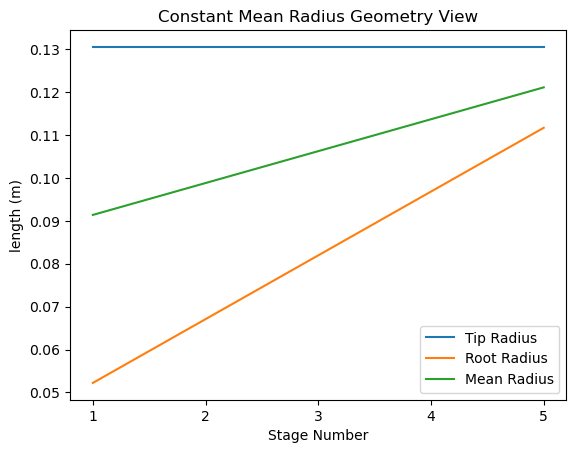

In [19]:
C1 = C_axial
T1 = T01-C1**2/2/Cp
P1 = P01*(T1/T01)**(gamma/(gamma-1))
rho1 = P1/R/T1*100000

inlet_radius_tip = (m_dot/(np.pi*rho1*C1)/(1-rr_rt**2))**0.5
inlet_radius_root = rr_rt*inlet_radius_tip
inlet_radius_mean = (inlet_radius_tip+inlet_radius_root)/2

C2 = C1
T02 = T01*(P_compressor)**((n_compressor-1)/n_compressor)
P02 = P_compressor*P01
T2 = T02-C2**2/2/Cp
a2 = (gamma*R*T2)**0.5

P2 = P02*(T2/T02)**(gamma/(gamma-1))
rho2 = P2/R/T2*100000
A2 = m_dot/rho2/C2

outlet_radius_tip = inlet_radius_tip
outlet_radius_root = (outlet_radius_tip**2-A2/np.pi)**0.5
outlet_radius_mean = (outlet_radius_tip+outlet_radius_root)/2

print("Geometry:")
print("Inlet")
print("Tip-",inlet_radius_tip)
print("Root-",inlet_radius_root)
print("Mean-",inlet_radius_mean)
print("Outlet")
print("Tip-",outlet_radius_tip)
print("Root-",outlet_radius_root)
print("Mean-",outlet_radius_mean)

tips = np.linspace(inlet_radius_tip,outlet_radius_tip,num_stages)
roots = np.linspace(inlet_radius_root,outlet_radius_root,num_stages)
means = [(t+r)/2 for t,r in zip(tips,roots)]
U_mean = [2*np.pi*N*m for m in means]

x = range(1,num_stages+1)

plt.figure()
plt.plot(x,tips,label="Tip Radius")
plt.plot(x,roots,label="Root Radius")
plt.plot(x,means,label="Mean Radius")
plt.legend()
plt.xticks(x)
plt.xlabel("Stage Number")
plt.ylabel("length (m)")
plt.title("Constant Mean Radius Geometry View")
plt.show()

### Compressor Stages

In [21]:
Beta1 = np.arctan(U_mean[0]/C_axial)
V1 = C_axial/np.cos(Beta1)
V2 = 0.72*V1
Beta2 = np.arccos(C_axial/V2)

work_done = [max(0.98-i*0.05,0.83) for i in range(num_stages)]

temperature_rise = [(T02-T01)/5 for _ in range(num_stages)]

C1_swirl = [0]
swirl_change = (Cp*temperature_rise[0]/work_done[0]+U_mean[0]*C1_swirl[-1])/U_mean[1]
C2_swirl = [C1_swirl[-1]+swirl_change]

Beta1 = np.arctan(U_mean[0]/C_axial)
Alpha1 = np.arctan(C1_swirl[-1]/C_axial)
Beta2 = np.arctan((U_mean[0]-C2_swirl[-1])/C_axial)
Alpha2 = np.arctan(C2_swirl[-1]/C_axial)

De_Haller = [np.cos(Beta1)/np.cos(Beta2)]

P_ratio = [(1+compressor_polytropic_efficiency*temperature_rise[0]/T01)**(gamma/(gamma-1))]

Inlet_P0 = [P01]
Outlet_P0 = [P_ratio[-1]*P01]

Inlet_T0 = [T01]
Outlet_T0 = [T01+temperature_rise[0]]

Lambda = [1-(C2_swirl[-1]+C1_swirl[-1])/2/U_mean[0],0.7]
Lambda.extend((num_stages-2)*[0.5])

def beta_equations(x,idx):
    return [temperature_rise[idx]*Cp/work_done[idx]/C_axial/U_mean[idx]-(np.tan(x[0])-np.tan(x[1])),
            Lambda[idx]/C_axial*2*U_mean[idx]-(np.tan(x[0])+np.tan(x[1]))]

for stage_num in range(1,num_stages):
    Beta1,Beta2 = fsolve(beta_equations,[1,1],args=stage_num)
    Alpha1 = np.arctan(U_mean[stage_num]/C_axial-np.tan(Beta1))
    Alpha2 = np.arctan(U_mean[stage_num]/C_axial-np.tan(Beta2))
    C1_swirl.append(C_axial*np.tan(Alpha1))
    C2_swirl.append(C_axial*np.tan(Alpha2))
    De_Haller.append(np.cos(Beta1)/np.cos(Beta2))
    P_ratio.append((1+compressor_polytropic_efficiency*temperature_rise[stage_num]/Outlet_T0[-1])**(gamma/(gamma-1)))
    Inlet_P0.append(Outlet_P0[-1])
    Outlet_P0.append(P_ratio[-1]*Inlet_P0[-1])
    Inlet_T0.append(Outlet_T0[-1])
    Outlet_T0.append(Inlet_T0[-1]+temperature_rise[stage_num])
    
df = {"Inlet_T0":Inlet_T0,
      "Outlet_T0":Outlet_T0,
      "Inlet_P0":Inlet_P0,
      "Outlet_P0":Outlet_P0,
      "P_ratio":P_ratio,
      "Inlet_swirl":C1_swirl,
      "Outlet_swirl":C2_swirl,
      "De_Haller":De_Haller}
df = pd.DataFrame(df)
df.index+=1
df

,Inlet_T0,Outlet_T0,Inlet_P0,Outlet_P0,P_ratio,Inlet_swirl,Outlet_swirl,De_Haller
1,288.150000,327.133333,1.013250,1.508452,1.488726,0.000000,150.604776,0.645264
2,327.133333,366.116666,1.508452,2.146616,1.423059,0.283634,158.985441,0.630430
3,366.116666,405.099998,2.146616,2.946985,1.372852,64.718541,220.701671,0.645230
4,405.099998,444.083331,2.946985,3.929042,1.333241,75.413809,229.978157,0.642898
5,444.083331,483.066664,3.929042,5.112488,1.301205,90.143486,235.220234,0.656183


## Lessons Learned